# ISLR - Python: Lab Ch 7 -- Moving Beyond Linearity

- [Import Wages Data](#Import-Wages-Data)
- [Polynomial Regression](#Polynomial-Regression)
- [Predictions](#Predictions)
- [ANOVA to Obtain Polynomial Degree](#AOVA-to-Obtain-Polynomial-Degree) 
- [Logit Model of Wage](#Logit Model of Wage)

In [68]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.stats.outliers_influence import summary_table
from scipy import stats
from matplotlib import pyplot as plt

%matplotlib inline
plt.style.use('ggplot')

## Import Wages Data

In [2]:
Wages = pd.read_csv('../../data/Wage.csv')
Wages.head()

,Unnamed: 0,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,155159,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,11443,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [3]:
# rename the 'Unnamed: 0' col to 'id'
Wages = Wages.rename(columns={'Unnamed: 0': 'id'})

# find out if there are any missing values
print(pd.isnull(Wages).any())

id            False
year          False
age           False
sex           False
maritl        False
race          False
education     False
region        False
jobclass      False
health        False
health_ins    False
logwage       False
wage          False
dtype: bool


## Ploynomial Regression

To reproduce figure 7.1 we will need to fit a fourth order polynomial of age to the wage data. $Wage=\beta_0 + \beta_1*age + \beta_2*age^2 + \beta_3*age^3 + \beta_4*age^4$. We will use statsmodels so we get the standard errors and other important statistics of the fit (as opposed to sklearn). There are several different notations to accomplish this in statsmodels. Here is one way:

In [72]:
model = smf.ols('wage ~ age + I(age**2)+ I(age**3) + I(age**4)', data=Wages)
estimate = model.fit()
print(estimate.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     70.69
Date:                Mon, 28 Nov 2016   Prob (F-statistic):           2.77e-57
Time:                        15:30:01   Log-Likelihood:                -15315.
No. Observations:                3000   AIC:                         3.064e+04
Df Residuals:                    2995   BIC:                         3.067e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept    -184.1542     60.040     -3.067      

## Predictions

We now make out-of-sample predictions and get the standard errors of the predictions (i.e. Confidence Interval for the mean).

In [73]:
# construct an array of ages to predict the wage for.
new_ages = np.linspace(Wages.age.min(), Wages.age.max(), num=1000)
# make the predictions using the predict method for the estimate
predictions = estimate.predict(exog=dict(age = new_ages))

# call the summary table at a (1-alpha)100% confidence interval level.
# This method returns back data an array with standard errors and confidence intervals
simpleTable, data, column_names = summary_table(estimate, alpha=0.05)

# Data contains the confidence intervals we want but we need to make sure we get the right
# columns so lets print off the names
print('column_names: ', column_names)

# Get confidence intervals for a given x. These correspond to columns 4 and 5. Note columns 6 and 7 are
# the prediction intervals.
predicted_mean_ci_low, predicted_mean_ci_high = data[:,4:6].T

column_names:  ['Obs', 'Dep Var\nPopulation', 'Predicted\nValue', 'Std Error\nMean Predict', 'Mean ci\n95% low', 'Mean ci\n95% upp', 'Predict ci\n95% low', 'Predict ci\n95% upp', 'Residual', 'Std Error\nResidual', 'Student\nResidual', "Cook's\nD"]


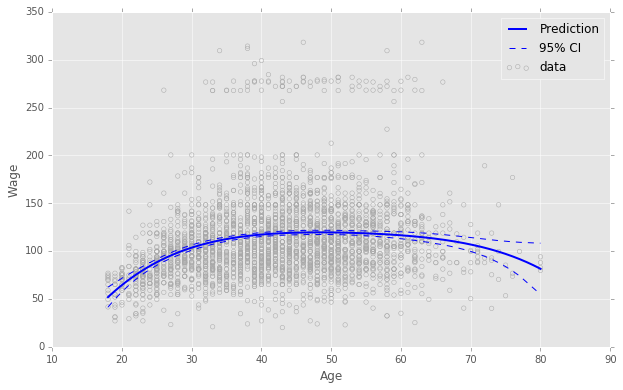

In [74]:
# Plot the data, the prediction and the 95% confidence intervals
fig, ax = plt.subplots(1,1, figsize = (10,6))
ax.scatter(Wages.age, Wages.wage, facecolors='none', edgecolors='darkgray', label="data")
ax.plot(new_ages,predictions, 'b-', lw=2, label='Prediction')

# sort the ages and use the order to sort the predicted values
order = np.argsort(Wages.age.values)
ax.plot(Wages.age.values[order], predicted_mean_ci_low[order], 'b--', label='95% CI')
ax.plot(Wages.age.values[order], predicted_mean_ci_high[order], 'b--')

ax.legend(loc='best');
ax.set_xlabel('Age');
ax.set_ylabel('Wage');

## ANOVA to Obtain Polynomial Degree

In ANOVA, we construct models for each order. Then we compare the models using $\frac{RSS_0-RSS}{q}/\frac{RSS}{n-p-1}$. Where $RSS_0$ is a reduced model with all but the last q coeffecients and RSS is the full model. The Null Hypothesis is $H_0: \beta_{p-q+1}=\beta_{p-q+2}=...=\beta_p = 0$. If the p-values for the model comparisons are small then we reject the null hypothesis and KEEP that particular coeffecient. 

In [75]:
# make models up to order 5.
est1 = smf.ols('wage ~ age', data=Wages).fit()
est2 = smf.ols('wage ~ age + I(age**2)', data=Wages).fit()
est3 = smf.ols('wage ~ age + I(age**2)+ I(age**3)', data=Wages).fit()
est4 = smf.ols('wage ~ age + I(age**2)+ I(age**3) + I(age**4)', data=Wages).fit()
est5 = smf.ols('wage ~ age + I(age**2)+ I(age**3) + I(age**4) + I(age**5)', data=Wages).fit()

# note only works when using formula api
# call anova to compare the models
anova = sm.stats.anova_lm(est1,est2,est3,est4,est5)
print(anova)

   df_resid           ssr  df_diff        ss_diff           F        Pr(>F)
0    2998.0  5.022216e+06      0.0            NaN         NaN           NaN
1    2997.0  4.793430e+06      1.0  228786.010128  143.593107  2.363850e-32
2    2996.0  4.777674e+06      1.0   15755.693664    9.888756  1.679202e-03
3    2995.0  4.771604e+06      1.0    6070.152124    3.809813  5.104620e-02
4    2994.0  4.770322e+06      1.0    1282.563017    0.804976  3.696820e-01


The p-value for the 1st-order to second order model is <2e-16, meaning that the quadratic term is significant and should be included. Similarly the second order to third order model has a p-value that is significant, so it should be included. The third to fourth order is just significant ~5% but the fourth to fifth order is not. So a fourth order model is indicated by the anova.

## Logit Model of Wage

Optimization terminated successfully.
         Current function value: 0.116870
         Iterations 12


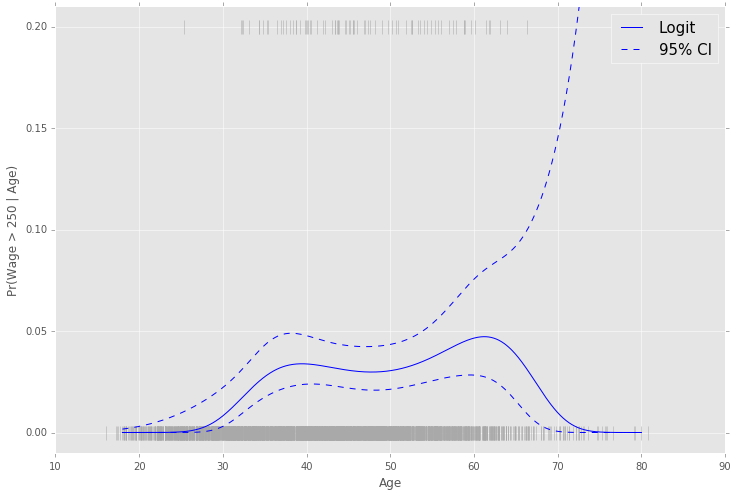

In [185]:
# Build Model #
###############
# We will predict the probability of a wage > 250k based on a fourth order polynomial of age using Logit func.
Wages['high_earner'] = (Wages.wage > 250).astype(float)
model = smf.logit('high_earner ~ age + I(age**2) + I(age**3) + I(age**4)', data=Wages)
# make fit
estimate = model.fit()
#print(estimate.summary())

# Make OOS Predictions #
########################
# construct an array of ages to predict the wage for.
new_ages = np.linspace(Wages.age.min(), Wages.age.max(), num=1000)
# make the predictions using the predict method for the estimate
predictions = estimate.predict(exog=dict(age=new_ages))

# Get CIs #
###########
# So for logit functions we don't get the CI for free. Recall the SE**2 = X.T * Sigma * X for a LINEAR model.
# Where X is (1,x_0,x_0**2, x_0**3, x_0**4) for each x_0 and Sigma is the covariance matrix. So we will compute the 
# linear model SE and transform it into logit function SE.
std_err = np.array([])
for age in new_ages:
    # construct the feature vector
    poly_age = np.array([[1,age,age**2,age**3,age**4]])
    temp = np.dot(estimate.cov_params(),poly_age.T)
    #compute the product to get linear model SE
    std_err = np.append(std_err, np.sqrt(np.dot(poly_age, temp)))
    
# Compute the critical value t_alpha/2,n-1 ~ alpha = 5%
crit_value = stats.t.isf(.05/2,len(Wages)-1)
# compute the confidence interval width
widths = crit_value*std_err
# compute the linear fit y_hats by asking predict to return linear=True
linear_fit_vals = estimate.predict(exog=dict(age=new_ages), linear=True)

# constuct upper and lower CIs
ui_linear = linear_fit_vals + widths
li_linear = linear_fit_vals - widths

# Transform the CIs under Logit 'link' function
ui = np.exp(ui_linear)/(1+np.exp(ui_linear))
li = np.exp(li_linear)/(1+np.exp(li_linear))

# Make plot
fig, ax = plt.subplots(figsize=(12,8))
# Function to randomly jitter the age data
def rand_jitter(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev
# add the data to the plot
ax.scatter(rand_jitter(Wages.age.values), Wages.high_earner.values/5, marker='|', color='darkgray', s=200)
# add prediction curve
ax.plot(new_ages,predictions,color='b',label='Logit')
# add 95% CI
ax.plot(new_ages, ui, color='b', linestyle='--', label='95% CI')
ax.plot(new_ages, li, color= 'b', linestyle='--')
# Set plt axis params
ax.set_ylim([-.01,0.21]);
ax.set_xlabel('Age')
ax.set_ylabel('Pr(Wage > 250 | Age)');
plt.legend(loc='best', prop={'size':15});
